# TECH CHALLENGE 2 - Prophet


TECH CHALLENGE 2

#Estudando e preparando os dados os Dados


In [5]:
import pandas as pd

df_ibovespa = pd.read_csv(r"C:\Users\T-GAMER\Documents\Estudos_Matheus_2025\dados_pos\Notebook - Dados Históricos - Ibovespa.csv")

df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,01.07.2025,139.549,138.855,139.695,138.855,"6,35M","0,50%"
1,30.06.2025,138.855,136.865,139.103,136.430,"7,68B","1,45%"
2,27.06.2025,136.866,137.113,137.209,136.469,"6,24B","-0,18%"
3,26.06.2025,137.114,135.767,137.353,135.756,"8,02B","0,99%"
4,25.06.2025,135.767,137.163,137.163,135.565,"7,71B","-1,02%"


In [6]:
df_ibovespa['Data'] = pd.to_datetime(
    df_ibovespa['Data'],
    format='%d.%m.%Y',
    errors='raise'
)

In [7]:
df_ibovespa["Vol."] = df_ibovespa["Vol."].str.replace("M", "e6").str.replace("B", "e9").str.replace("K", "e3").str.replace(",", ".").astype(float)

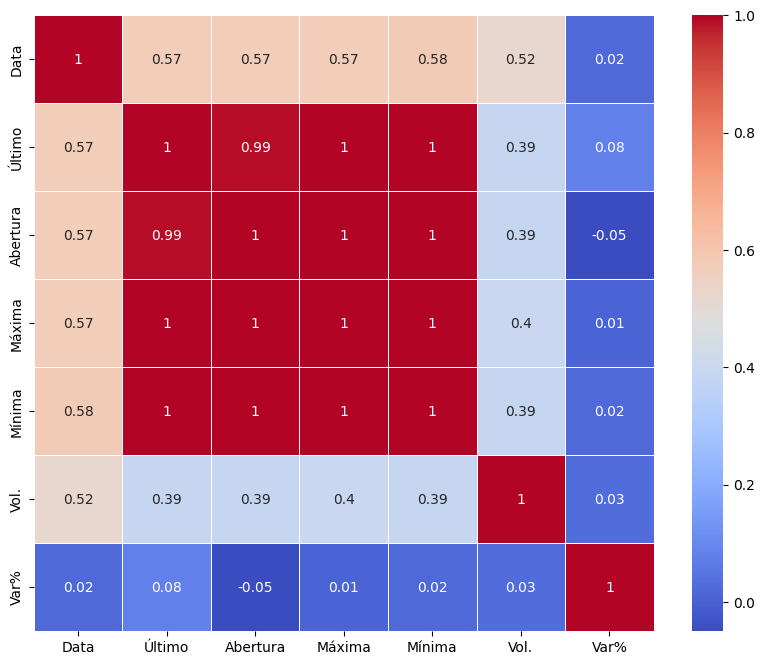

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ibovespa['Var%'] = df_ibovespa['Var%'].astype(str).str.replace('%', '').str.replace(',', '.').astype(float) / 100

correlation_metrics = df_ibovespa.corr().round(2)

fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(correlation_metrics, annot=True,linewidths= .5, ax=ax, cmap="coolwarm")

plt.show()

In [9]:
df_ibovespa.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

#Iniciando o modelo

In [10]:
!pip install prophet


  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
Using cached prophet-1.1.7-py3-none-win_amd64.whl (13.3 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\T-GAMER\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\cmdstan-2.33.1\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_deprecated_header_message_guard.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\T-GAMER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
from sklearn import metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [12]:
df_ibovespa.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)

In [13]:
df_ibovespa.head()

,ds,y,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-07-01,139.549,138.855,139.695,138.855,6.350000e+06,0.0050
1,2025-06-30,138.855,136.865,139.103,136.430,7.680000e+09,0.0145
2,2025-06-27,136.866,137.113,137.209,136.469,6.240000e+09,-0.0018
3,2025-06-26,137.114,135.767,137.353,135.756,8.020000e+09,0.0099
4,2025-06-25,135.767,137.163,137.163,135.565,7.710000e+09,-0.0102


In [14]:
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        1119 non-null   datetime64[ns]
 1   y         1119 non-null   float64       
 2   Abertura  1119 non-null   float64       
 3   Máxima    1119 non-null   float64       
 4   Mínima    1119 non-null   float64       
 5   Vol.      1119 non-null   float64       
 6   Var%      1119 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 61.3 KB


In [15]:
df_ibovespa.set_index('ds', inplace=True)

In [16]:
df_ibovespa.reset_index(inplace=True)

In [17]:
train_set = df_ibovespa.iloc[:-30]

test_set = df_ibovespa.iloc[-30:]

In [ ]:
m = Prophet()

m.fit(df_ibovespa)

22:15:25 - cmdstanpy - INFO - Chain [1] start processing
22:15:26 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future = m.make_future_dataframe(periods=60, freq='B')

forecast = m.predict(future)

#Apresentando os resultados

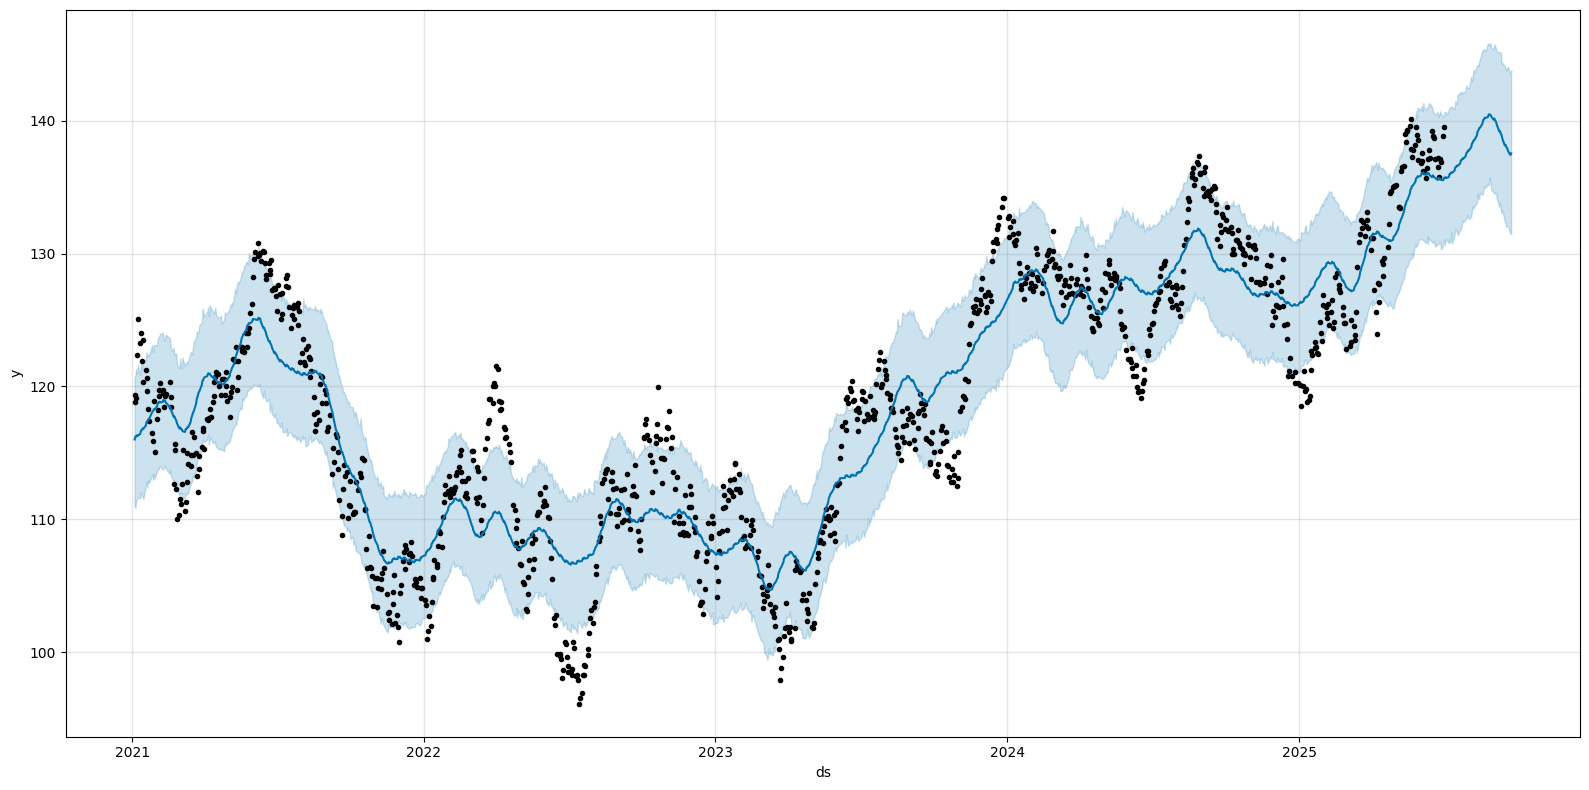

In [20]:
fig = m.plot(forecast, figsize=(16, 8))

In [26]:
import pandas as pd
import numpy as np

# Garante que as datas estão como datetime
df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'])
forecast['ds']    = pd.to_datetime(forecast['ds'])

# Data de corte (último ponto real)
data_corte = df_ibovespa['ds'].max()

# Próximos 30 dias previstos
forecast_future_30 = (
    forecast[
        (forecast['ds'] > data_corte) &
        (forecast['ds'] <= data_corte + pd.Timedelta(days=30))
    ]
    .copy()
    .reset_index(drop=True)
)

# 1) Pega o último valor real do IBOVESPA
last_real = df_ibovespa.loc[df_ibovespa['ds'] == data_corte, 'y'].values[0]

# 2) Cria coluna com o “valor do dia anterior” para comparar
forecast_future_30['prev'] = forecast_future_30['yhat'].shift(1)
forecast_future_30.loc[0, 'prev'] = last_real

# 3) Define Tendência: Subir se yhat > prev, senão Descer
forecast_future_30['Tendência'] = np.where(
    forecast_future_30['yhat'] > forecast_future_30['prev'],
    'Subir',
    'Descer'
)

# 4) Monta a tabela final
tabela = forecast_future_30[['ds', 'yhat', 'Tendência']]
tabela.columns = ['Data', 'Previsão_IBOVESPA', 'Tendência_Próximo_Dia']

# 5) Exibe
print(tabela.to_string(index=False))


      Data  Previsão_IBOVESPA Tendência_Próximo_Dia
2025-07-02         135.676683                Descer
2025-07-03         135.750650                 Subir
2025-07-04         135.681200                Descer
2025-07-07         135.763499                 Subir
2025-07-08         135.993576                 Subir
2025-07-09         136.002853                 Subir
2025-07-10         136.110193                 Subir
2025-07-11         136.071405                Descer
2025-07-14         136.227313                 Subir
2025-07-15         136.475518                 Subir
2025-07-16         136.499794                 Subir
2025-07-17         136.619181                 Subir
2025-07-18         136.589742                Descer
2025-07-21         136.761161                 Subir
2025-07-22         137.011853                 Subir
2025-07-23         137.038121                 Subir
2025-07-24         137.159540                 Subir
2025-07-25         137.132704                Descer
2025-07-28  

#Testando modelo #


In [27]:
m = Prophet()
m.fit(train_set)

22:23:20 - cmdstanpy - INFO - Chain [1] start processing
22:23:20 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future_test = test_set[['ds']]  # só as datas
forecast_test = m.predict(future_test)


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Valores reais
y_true = test_set['y'].values

# Previsões do modelo
y_pred = forecast_test['yhat'].values

# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 7.262081454628685
MSE: 57.182392202284376
RMSE: 7.56190400641825


In [ ]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 6.04%
